In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
import numpy as np, pandas as pd, statsmodels.api as sm
from statsmodels.discrete.discrete_model import NegativeBinomial
import warnings

# Data

In [3]:
data = pd.read_csv("../data/processed/merged_features.csv").drop(["Unnamed: 0"], axis=1)
data


,Year,Average temperature (degrees C),Average wind Speed (km/h),Average visibility (km),Yearly Average of Daily Volume,BICYCLE COLLISIONS,MOTORCYCLE COLLISIONS,PEDESTRIAN COLLISIONS,Total Collisions,Total Fatalities,FATALITIES: INTERSECTION,FATALITIES: MIDBLOCK,INJURIES: INTERSECTION,INJURIES: MIDBLOCK,FATAL COLLISIONS,SERIOUS INJURY COLLISIONS,MINOR INJURY COLLISIONS,TOTAL SERIOUS & MINOR INJURY COLLISIONS,TOTAL FATAL & INJURY COLLISIONS,RATIO FATALITIES + INJURIES
0,2010,3.352347,11.053013,15.908633,NaN,182,211,306,28480,27,13,14,3314,1307,24,423,3345,3768,3792,0.133146
1,2011,3.445416,13.142069,16.600753,12193.134872,190,199,316,23442,22,12,9,3010,1256,22,389,3093,3482,3504,0.149475
2,2012,4.414667,12.638326,16.167048,11896.012759,177,157,296,23243,27,5,22,3003,1200,26,426,2937,3363,3389,0.145807
3,2013,2.410434,12.647422,18.062787,11975.502906,177,172,298,24805,23,11,12,2825,1127,23,375,2848,3223,3246,0.130861
4,2014,2.810970,12.625795,18.412174,12330.219780,177,163,319,24627,23,10,13,2515,1028,22,345,2567,2912,2934,0.119138
5,2015,4.941236,12.332064,18.046739,13160.213272,178,208,316,25516,32,18,13,2727,948,30,329,2704,3033,3063,0.120042
6,2016,4.812860,12.175093,17.538099,12688.032454,171,191,292,23139,22,11,10,2368,778,21,281,2375,2656,2677,0.115692
7,2017,3.731350,12.627638,17.347945,11896.841582,143,154,270,23905,27,13,13,2393,822,26,297,2413,2710,2736,0.114453
8,2018,1.785195,12.315178,17.535189,11064.122497,130,143,250,24003,19,8,11,2302,848,19,287,2323,2610,2629,0.109528
9,2019,2.479827,12.075129,18.848681,11392.131920,130,104,221,21943,14,8,6,1813,613,14,244,1822,2066,2080,0.094791


# Model - Yearly Collision Rate

### Relationship between Predictor and Target Variable

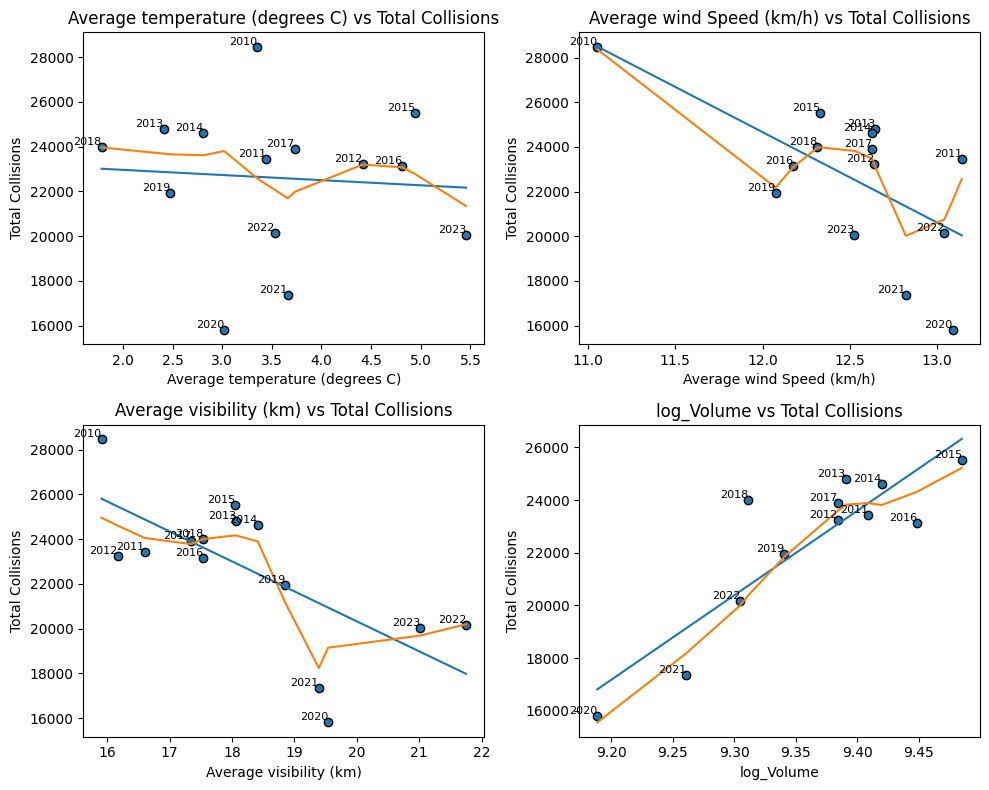

In [10]:
features = [
    "Average temperature (degrees C)",
    "Average wind Speed (km/h)",
    "Average visibility (km)",
    "Yearly Average of Daily Volume"
]
y_col = "Total Collisions"


if "log_Volume" not in data.columns:
    data = data.copy()
    data["log_Volume"] = np.log(data["Yearly Average of Daily Volume"].replace(0, np.nan))

plot_features = features.copy()
plot_features[-1] = "log_Volume"

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.ravel()

for ax, feat in zip(axes, plot_features):
    sub = data[[feat, y_col, "Year"]].dropna()
    x = sub[feat].values
    y = sub[y_col].values

    ax.scatter(x, y, edgecolors='k')

    # linear fit line
    if len(x) >= 2:
        coef = np.polyfit(x, y, 1)
        xs = np.linspace(np.nanmin(x), np.nanmax(x), 200)
        ax.plot(xs, np.polyval(coef, xs))

    # LOWESS smooth
    if len(x) >= 3:
        lo = lowess(y, x, frac=0.6, return_sorted=True)
        ax.plot(lo[:, 0], lo[:, 1])

    for xi, yi, yr in zip(sub[feat], sub[y_col], sub["Year"]):
        ax.text(xi, yi, str(int(yr)), fontsize=8, va="bottom", ha="right")

    ax.set_xlabel(feat)
    ax.set_ylabel(y_col)
    ax.set_title(f"{feat} vs {y_col}")

plt.tight_layout()
plt.show()

In [13]:
mean_val = data["Total Collisions"].mean()
var_sample = data["Total Collisions"].var(ddof=1)   # sample variance
dispersion = var_sample / mean_val

print(f"Mean = {mean_val}")
print(f"Sample variance = {var_sample}")
print(f"Dispersion = {dispersion}")

Mean = 22605.071428571428
Sample variance = 11052170.532967033
Dispersion = 488.92437999544495


> The target variable `Total Collisions` is a discrete variable. We must use Generalized Linear Model instead of Ordinary Least square (OLS), which assumes target variable is continous. The dispersion is 489, which is greater than 1. Poisson distrubution assumes mean = variance, which translated to dispersion ≈ 1. Since this is not the case, and data is extremely overdispersed relative to Poisson's distrubution - we must use Negative-Binomial GLM instead of a Poisson GLM.

### Modelling

In [15]:
y_col = "Total Collisions"
vol_col = "Yearly Average of Daily Volume"
candidates = [
    "Average temperature (degrees C)",
    "Average wind Speed (km/h)",
    "Average visibility (km)",
]

df = data[[y_col, vol_col] + candidates].dropna().copy()
y = df[y_col].astype(float).values
X_all = df[candidates].astype(float)
exposure = df[vol_col].astype(float).values


def fit_nb(exog):
    exog = sm.add_constant(exog, has_constant="add")
    return NegativeBinomial(y, exog, exposure=exposure).fit(disp=False, maxiter=200)

def aicc(res):
    n = len(y); k = res.params.size
    return res.aic + (2*k*(k+1)) / max(n - k - 1, 1)


selected, remaining = [], candidates.copy()

res_best = fit_nb(pd.DataFrame(index=X_all.index))
best_aicc = aicc(res_best)

improved = True
while improved and remaining:
    improved, pick, pick_res, pick_aicc = False, None, None, None
    for var in remaining:
        res_try = fit_nb(pd.concat([X_all[selected + [var]]], axis=1))
        cur_aicc = aicc(res_try)
        if cur_aicc < best_aicc - 2:  # require ΔAICc ≤ -2
            if (not improved) or (cur_aicc < pick_aicc):
                improved, pick, pick_res, pick_aicc = True, var, res_try, cur_aicc
    if improved:
        selected.append(pick)
        remaining.remove(pick)
        res_best, best_aicc = pick_res, pick_aicc


print("Selected predictors (beyond exposure=volume):", selected or "None (intercept-only)")
print("\nCoefficient table:")
print(res_best.summary().tables[1])


Selected predictors (beyond exposure=volume): None (intercept-only)

Coefficient table:
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6468      0.024     27.508      0.000       0.601       0.693
alpha          0.0066      0.003      2.434      0.015       0.001       0.012


### Metrics:

In [52]:
# Check for selected Predictictors:
try:
    selected  # if already defined
except NameError:
    selected = []  # fallback to intercept-only if none selected

print("The selected predictors:", selected or "None - We are using intercept only.\n")

# Prepare Dataframe containing only target and selected predictors
y_col = "Total Collisions"
vol_col = "Yearly Average of Daily Volume"
cols = [y_col, vol_col] + selected
df = data[cols].dropna().copy()
df = df[df[vol_col] > 0].reset_index(drop=True)

y = df[y_col].astype(float)
exposure = df[vol_col].astype(float)
X = df[selected].astype(float) if selected else pd.DataFrame(index=df.index)  # design


# Fit Negative Binomial GLM
def fit_nb(y_, X_, exp_):
    exog = sm.add_constant(X_, has_constant="add")
    model = NegativeBinomial(y_, exog, exposure=exp_)
    return model.fit(disp=False, maxiter=500)

# Get Predictions - the loop performs Leave One Year Out
preds, actuals = [], []
n = len(df)

for pos in range(n):
    train_mask = np.arange(n) != pos #Leave the datapoint at location == pos.
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        res = fit_nb(y.iloc[train_mask], X.iloc[train_mask], exposure.iloc[train_mask])

    exog_i = sm.add_constant(X.iloc[[pos]], has_constant="add")
    exp_i = float(exposure.iloc[pos])
    mu_i = res.predict(exog=exog_i, exposure=exp_i)
    mu_val = np.asarray(mu_i).ravel()[0]

    preds.append(float(mu_val))
    actuals.append(float(y.iloc[pos]))

preds = np.array(preds); actuals = np.array(actuals)

# Metrics
mae  = np.mean(np.abs(actuals - preds))
rmse = np.sqrt(np.mean((actuals - preds)**2))
mask_nonzero = actuals != 0
mape = (np.mean(np.abs((actuals[mask_nonzero] - preds[mask_nonzero]) / actuals[mask_nonzero])) * 100
        if mask_nonzero.any() else np.nan)
accuracy_pct = max(0.0, 100.0 - mape) if not np.isnan(mape) else np.nan

# Print Metrics - LOYO = Leave-One-Year-Out:
print(f"LOYO MAE  = {mae:.2f}")
print(f"LOYO RMSE = {rmse:.2f}")
print(f"LOYO MAPE = {mape:.2f}%")
print(f"Accuracy = {accuracy_pct:.2f}%")


The selected predictors: None - We are using intercept only.

LOYO MAE  = 1442.52
LOYO RMSE = 1800.24
LOYO MAPE = 7.02%
Accuracy = 92.98%
